Reading IOS data in Rich's directory using Rob's reader.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import os
import datetime
import pandas as pd
import netCDF4 as nc
import datetime

from salishsea_tools.nowcast import figures
from salishsea_tools import viz_tools, nc_tools, tidetools
from glob import glob
%matplotlib inline

In [2]:
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13'}

In [3]:
import ACTDR

In [4]:
ACTDR.load_dat('SOG.dat')

> open  SOG.dat
> load CTD_DAT
> load STANDARD_KEYS
> close  SOG.dat
> complete


In [5]:
def select_cast_month(Month):
    """This function was made to select 
        the cast in the SoG region in the
        specific month """
    
    s_cast = []
    for cast in ACTDR.CTD_DAT:
        if (cast['Longitude'] > -123.7)& (cast['Longitude']<-122.5) & (cast['Latitude']\
             > 48.76) & (cast['Latitude'] < 49.50) & (cast['Month'] == Month):
            s_cast.append(cast)
    return s_cast

In [6]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [8]:
def compare_cast_SoG(imin,imax,jmin,jmax,Month,num):
    month = {'1':{'name': 'Jan'},'2':{'name': 'Feb'},\
    '3':{'name': 'Mar'}, '4':{'name': 'Apr'},'5':{'name': 'May'},\
    '6':{'name': 'Jun'},'7':{'name': 'Jul'},'8':{'name': 'Aug'},\
    '9':{'name': 'Sep'}, '10':{'name': 'Oct'}, '11':{'name': 'Nov'},\
    '12':{'name': 'Dec'}}
    fig,axs=plt.subplots(1,2,figsize=(10,5))
    #map
    ax=axs[0]
    grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    viz_tools.plot_coastline(ax,grid)
    ax.plot([imin,imax],[jmin,jmin],'r-')
    ax.plot([imin,imax],[jmax,jmax],'r-')
    ax.plot([imin,imin],[jmin,jmax],'r-')
    ax.plot([imax,imax],[jmin,jmax],'r-')
    s_cast = select_cast_month(Month)
    ax=axs[1]
    count = 0
    ##prepare nowcasts results
    for cast in s_cast:
        if Month >= 10:
            run_date = datetime.datetime(2014, Month,cast['Day'])
        else:
            run_date = datetime.datetime(2015, Month,cast['Day'])
        # Results dataset location
        results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
        sal_hr = grid_T_hr.variables['vosaline']
        depth = grid_T_hr.variables['deptht']
        bathyy, X, Y = tidetools.get_SS2_bathy_data()
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        t = 3 ## how to select t_hour???
        #sal_hr[t,:,x1,y1] = np.ma.masked_values(sal_hr[t,:,x1,y1], 0)
        cmap=plt.get_cmap('spectral', 20)
        ax.plot(sal_hr[t, : , x1, y1], depth[:], marker = '*', c =cmap(cast['Day']-1))
        #sal_hr = np.ma.masked_values(sal_hr[t], 0)
        ##profile comparison          
        ax.plot(cast['Salinity'],cast['Depth'],marker='o',c=cmap(cast['Month']-1))
        count=count+1
        ax.axis([0,35,400,0])
        ax.grid('on')   
        ax.set_title('Comparison in '+ str(month[num]['name']))
    ax.set_xlabel('salinity', **axis_font)
    ax.set_ylabel('depth [m]', **axis_font)
    return fig

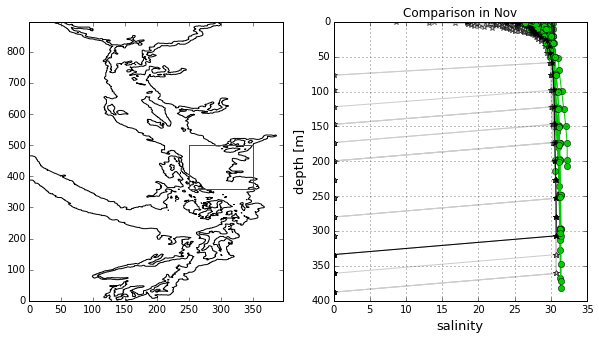

In [9]:
## Nov
fig = compare_cast_SoG(250, 350, 360, 500, 11, '11')

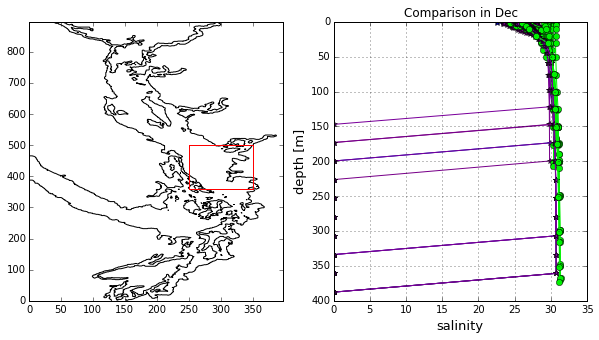

In [10]:
## Dec
fig = compare_cast_SoG(250, 350, 360, 500, 12,'12')

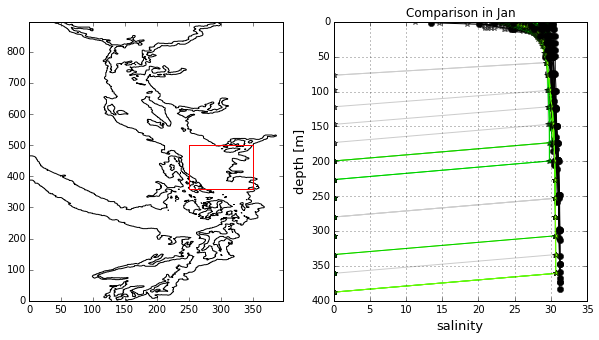

In [11]:
## Jan
fig = compare_cast_SoG(250, 350, 360, 500, 1, '1')

IndexError: index 0 is out of bounds for axis 0 with size 0

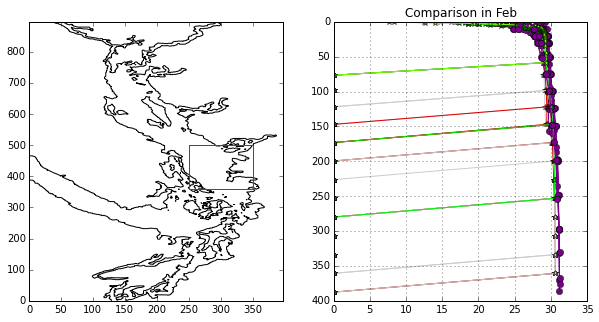

In [12]:
fig = compare_cast_SoG(250, 350, 360, 500, 2, '2')

In [13]:
s_cast = select_cast_month(2)
run_date = datetime.datetime(2015, 2,s_cast[7]['Day'])
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
sal_hr = grid_T_hr.variables['vosaline']
depth = grid_T_hr.variables['deptht']
bathyy, X, Y = tidetools.get_SS2_bathy_data()
[x1, y1] = tidetools.find_closest_model_point(s_cast[7]['Longitude'] , \
s_cast[7]['Latitude'],X,Y,bathyy)
t = 3 ## how to select t_hour???
        #sal_hr[t,:,x1,y1] = np.ma.masked_values(sal_hr[t,:,x1,y1], 0)
print sal_hr[t, : , x1, y1]

[ 14.6490736   19.85228729  23.19014168  24.68651772  25.49544716
  25.98778152  26.31933975  26.57270241  26.789505    26.98542213
  27.16483879  27.32946587  27.48069763  27.6199913   27.74902344
  27.86991501  27.98558235  28.10040474  28.22101021  28.35560799
  28.50676346  28.65609741  28.80877686  28.9412117   29.07229042
  29.22558403  29.63742638  30.05168343  30.2458477   30.32364845
  30.37488937   0.           0.           0.           0.           0.           0.
   0.           0.           0.        ]


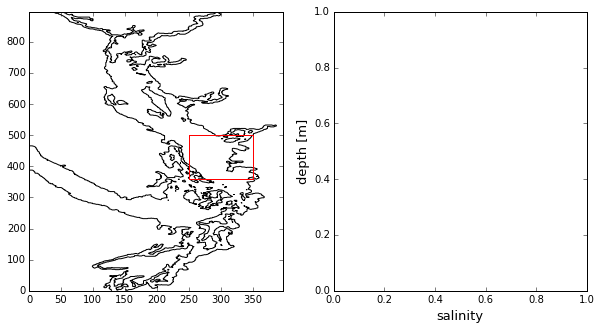

In [14]:
fig = compare_cast_SoG(250, 350, 360, 500, 3, '3')

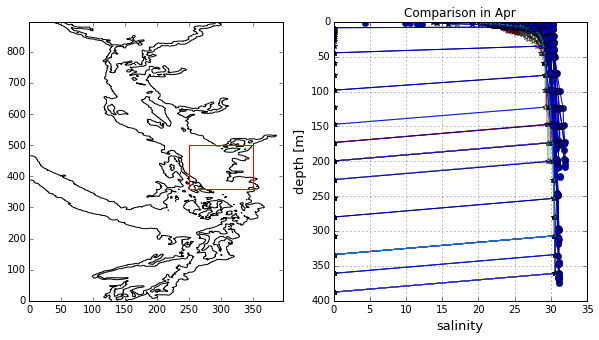

In [15]:
##April
fig = compare_cast_SoG(250, 350, 360, 500, 4, '4')

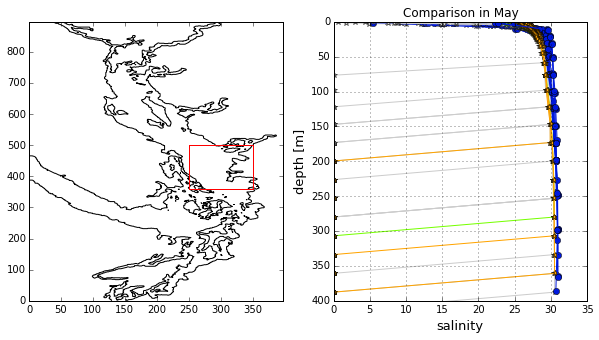

In [16]:
## May
fig = compare_cast_SoG(250, 350, 360, 500, 5, '5')

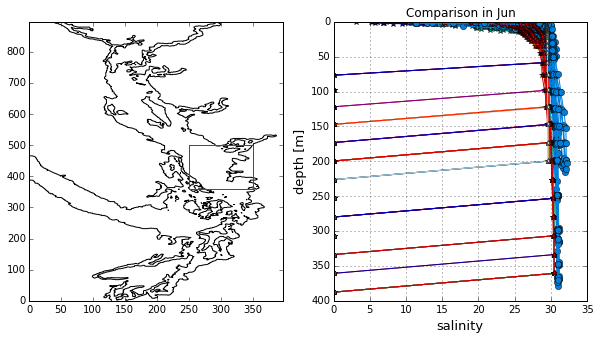

In [18]:
## June
fig = compare_cast_SoG(250, 350, 360, 500, 6,'6')

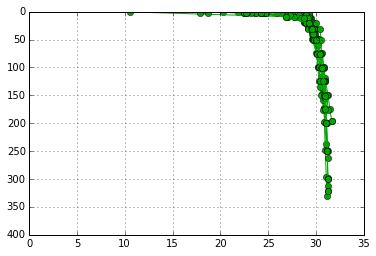

In [29]:
s_cast = select_cast_month(Month = 10)
cmap=plt.get_cmap('spectral', 20)
count=0
for cast in s_cast:
    plt.plot(cast['Salinity'],cast['Depth'],marker='o',c=cmap(cast['Month']-1))
    count=count+1
plt.axis([0,35,400,0])
plt.grid()